In [21]:
# -*- coding: utf-8 -*-
import numpy as np
import nibabel as nib
import os
from tqdm.notebook import tqdm
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#import method for dilation
from scipy.ndimage import binary_dilation, binary_fill_holes

lung_path = r"D:\script_di_ale\output\lungMask"
segmentation_path = r"D:\script_di_ale\output\labelsTr"

ct_path = r"D:\script_di_ale\output\imagesTr"
hadamarded_path = r"D:\script_di_ale\output\hadamard"

# check how much of the segmentation is inside the lung mask divided by the total segmentation
# this sees how much of the segmentation is inside the lung mask
def intersection_percentage(lung, segmentation):
    intersection = np.logical_and(lung, segmentation)
    return np.sum(intersection) / np.sum(segmentation)

lung_files = sorted(os.listdir(lung_path))
results = []
for i in tqdm(range(len(lung_files)), colour="blue", desc="testing overlap, have lunch or something"):
    # if files does not end with nii.gz skip
    if not lung_files[i].endswith(".nii.gz"):
        continue

    lung = nib.load(os.path.join(lung_path, lung_files[i])).get_fdata()
    

    # apply dilation to the lung mask
    lung = binary_dilation(lung, iterations=10)

    # apply fill holes to the lung mask
    lung = binary_fill_holes(lung)

    

    segmentation = nib.load(os.path.join(segmentation_path, lung_files[i])).get_fdata()
    percentage = intersection_percentage(lung, segmentation)
    results.append(percentage)
    print(f"{lung_files[i]}: {percentage}")

    ct = nib.load(os.path.join(ct_path, lung_files[i]).replace(".nii.gz", "_0000.nii.gz"))
    ct_img = ct.get_fdata()
    # get min value of ct
    min_ct = np.min(ct_img)
    # bring min of ct to 0
    ct_img -= min_ct
    # hadamard product between ct and lung mask
    hadamard = ct_img * lung

    # add min value back to hadamard
    hadamard += min_ct
    # save hadamard product
    new_nifti = nib.Nifti1Image(hadamard, ct.affine, ct.header)
    nib.save(new_nifti, os.path.join(hadamarded_path, lung_files[i]))
 
    
# kde of the results




testing overlap, have a coffee or something:   0%|          | 0/291 [00:00<?, ?it/s]

INT1010016.nii.gz: 1.0
INT1010023.nii.gz: 0.989337822671156
INT1010024.nii.gz: 0.12136060922105239


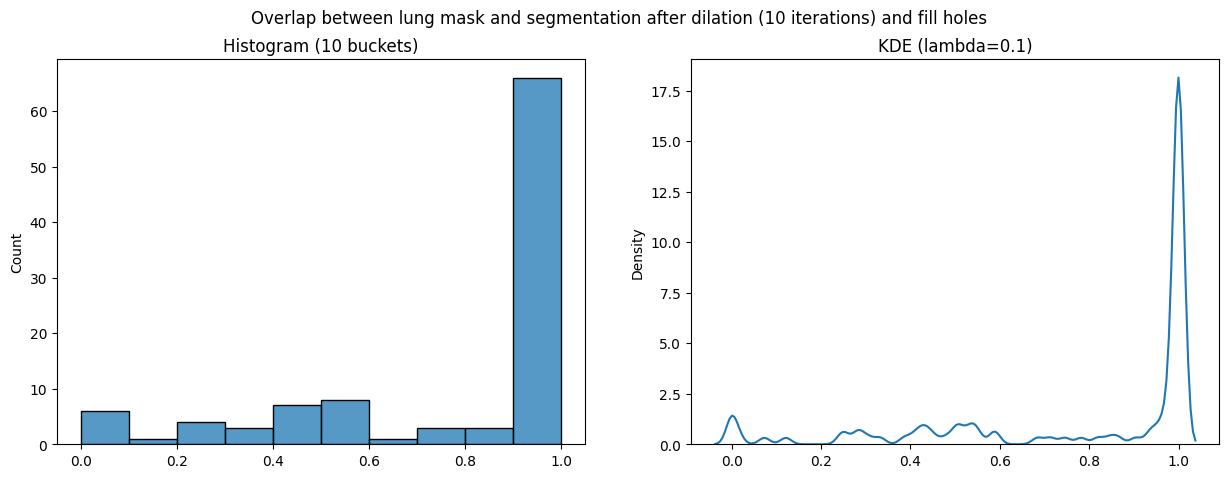

Mean: 0.792220564238918
Std: 0.3110382846775142


,overlap
count,102.000000
mean,0.792221
std,0.312574
min,0.000000
25%,0.545120
50%,0.998777
75%,1.000000
max,1.000000


In [19]:
#two subplots
fig, axs = plt.subplots(1,2, figsize=(15,5))
axs = axs.flatten()
#histogram 10 buckets in first subplot
sns.histplot(results, bins=10, ax=axs[0])

sns.kdeplot(results, bw_adjust=0.1, ax=axs[1])
#add title for whole figure
fig.suptitle("Overlap between lung mask and segmentation after dilation (10 iterations) and fill holes")
#add title for each subplot
axs[0].set_title("Histogram (10 buckets)")
axs[1].set_title("KDE (lambda=0.1)")
plt.show()
print(f"Mean: {np.mean(results)}")
print(f"Std: {np.std(results)}")
# show all the results
results_df = pd.DataFrame(results, columns=["overlap"])
results_df.describe()

55 cuore